## Preparation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline  
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectFpr, f_classif, chi2
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
import gurobipy as gp
from gurobipy import GRB

In [15]:
data = pd.read_csv('ifood_df.csv') 

In [16]:
data.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,marital_Together,marital_Widow,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,MntTotal,MntRegularProds,AcceptedCmpOverall
0,58138.0,0,0,58,635,88,546,172,88,88,...,0,0,0,0,1,0,0,1529,1441,0
1,46344.0,1,1,38,11,1,6,2,1,6,...,0,0,0,0,1,0,0,21,15,0
2,71613.0,0,0,26,426,49,127,111,21,42,...,1,0,0,0,1,0,0,734,692,0
3,26646.0,1,0,26,11,4,20,10,3,5,...,1,0,0,0,1,0,0,48,43,0
4,58293.0,1,0,94,173,43,118,46,27,15,...,0,0,0,0,0,0,1,407,392,0


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Income                2205 non-null   float64
 1   Kidhome               2205 non-null   int64  
 2   Teenhome              2205 non-null   int64  
 3   Recency               2205 non-null   int64  
 4   MntWines              2205 non-null   int64  
 5   MntFruits             2205 non-null   int64  
 6   MntMeatProducts       2205 non-null   int64  
 7   MntFishProducts       2205 non-null   int64  
 8   MntSweetProducts      2205 non-null   int64  
 9   MntGoldProds          2205 non-null   int64  
 10  NumDealsPurchases     2205 non-null   int64  
 11  NumWebPurchases       2205 non-null   int64  
 12  NumCatalogPurchases   2205 non-null   int64  
 13  NumStorePurchases     2205 non-null   int64  
 14  NumWebVisitsMonth     2205 non-null   int64  
 15  AcceptedCmp3         

## Data Cleaning and Visualisation

In [18]:
# perform feature engineering
data['Frequency'] = (
    data['NumWebPurchases'] + 
    data['NumCatalogPurchases'] + 
    data['NumStorePurchases']
)
data['Monetary'] = (
    data['MntWines'] + data['MntFruits'] + data['MntMeatProducts'] +
    data['MntFishProducts'] + data['MntSweetProducts'] + data['MntGoldProds']
)

data['Wines_Ratio'] = data['MntWines'] / (data['Monetary'] + 1e-5)
data['Meat_Ratio'] = data['MntMeatProducts'] / (data['Monetary'] + 1e-5)
data['Web_Ratio'] = data['NumWebPurchases'] / (data['Frequency'] + 1e-5)
data['Catalog_Ratio'] = data['NumCatalogPurchases'] / (data['Frequency'] + 1e-5)


for col in ['Income','Monetary','MntWines','MntMeatProducts']:
    if col in data.columns:
        data[f'log_{col}'] = np.log1p(data[col])


In [19]:
# distinguish categorical columns and numerical columns for data visualisation
categorical_columns = []
numerical_columns = []
for column in data.columns:
    if column == 'Response':  
        continue
    elif len(sorted(data[column].unique())) == 1: 
        continue
    elif column in ['MntTotal','MntRegularProds','AcceptedCmpOverall']: 
        continue
    elif len(sorted(data[column].unique())) <= 10: 
        categorical_columns.append(column)
    else:
        numerical_columns.append(column)

categorical_columns, numerical_columns

(['Kidhome',
  'Teenhome',
  'AcceptedCmp3',
  'AcceptedCmp4',
  'AcceptedCmp5',
  'AcceptedCmp1',
  'AcceptedCmp2',
  'Complain',
  'marital_Divorced',
  'marital_Married',
  'marital_Single',
  'marital_Together',
  'marital_Widow',
  'education_2n Cycle',
  'education_Basic',
  'education_Graduation',
  'education_Master',
  'education_PhD'],
 ['Income',
  'Recency',
  'MntWines',
  'MntFruits',
  'MntMeatProducts',
  'MntFishProducts',
  'MntSweetProducts',
  'MntGoldProds',
  'NumDealsPurchases',
  'NumWebPurchases',
  'NumCatalogPurchases',
  'NumStorePurchases',
  'NumWebVisitsMonth',
  'Age',
  'Customer_Days',
  'Frequency',
  'Monetary',
  'Wines_Ratio',
  'Meat_Ratio',
  'Web_Ratio',
  'Catalog_Ratio',
  'log_Income',
  'log_Monetary',
  'log_MntWines',
  'log_MntMeatProducts'])

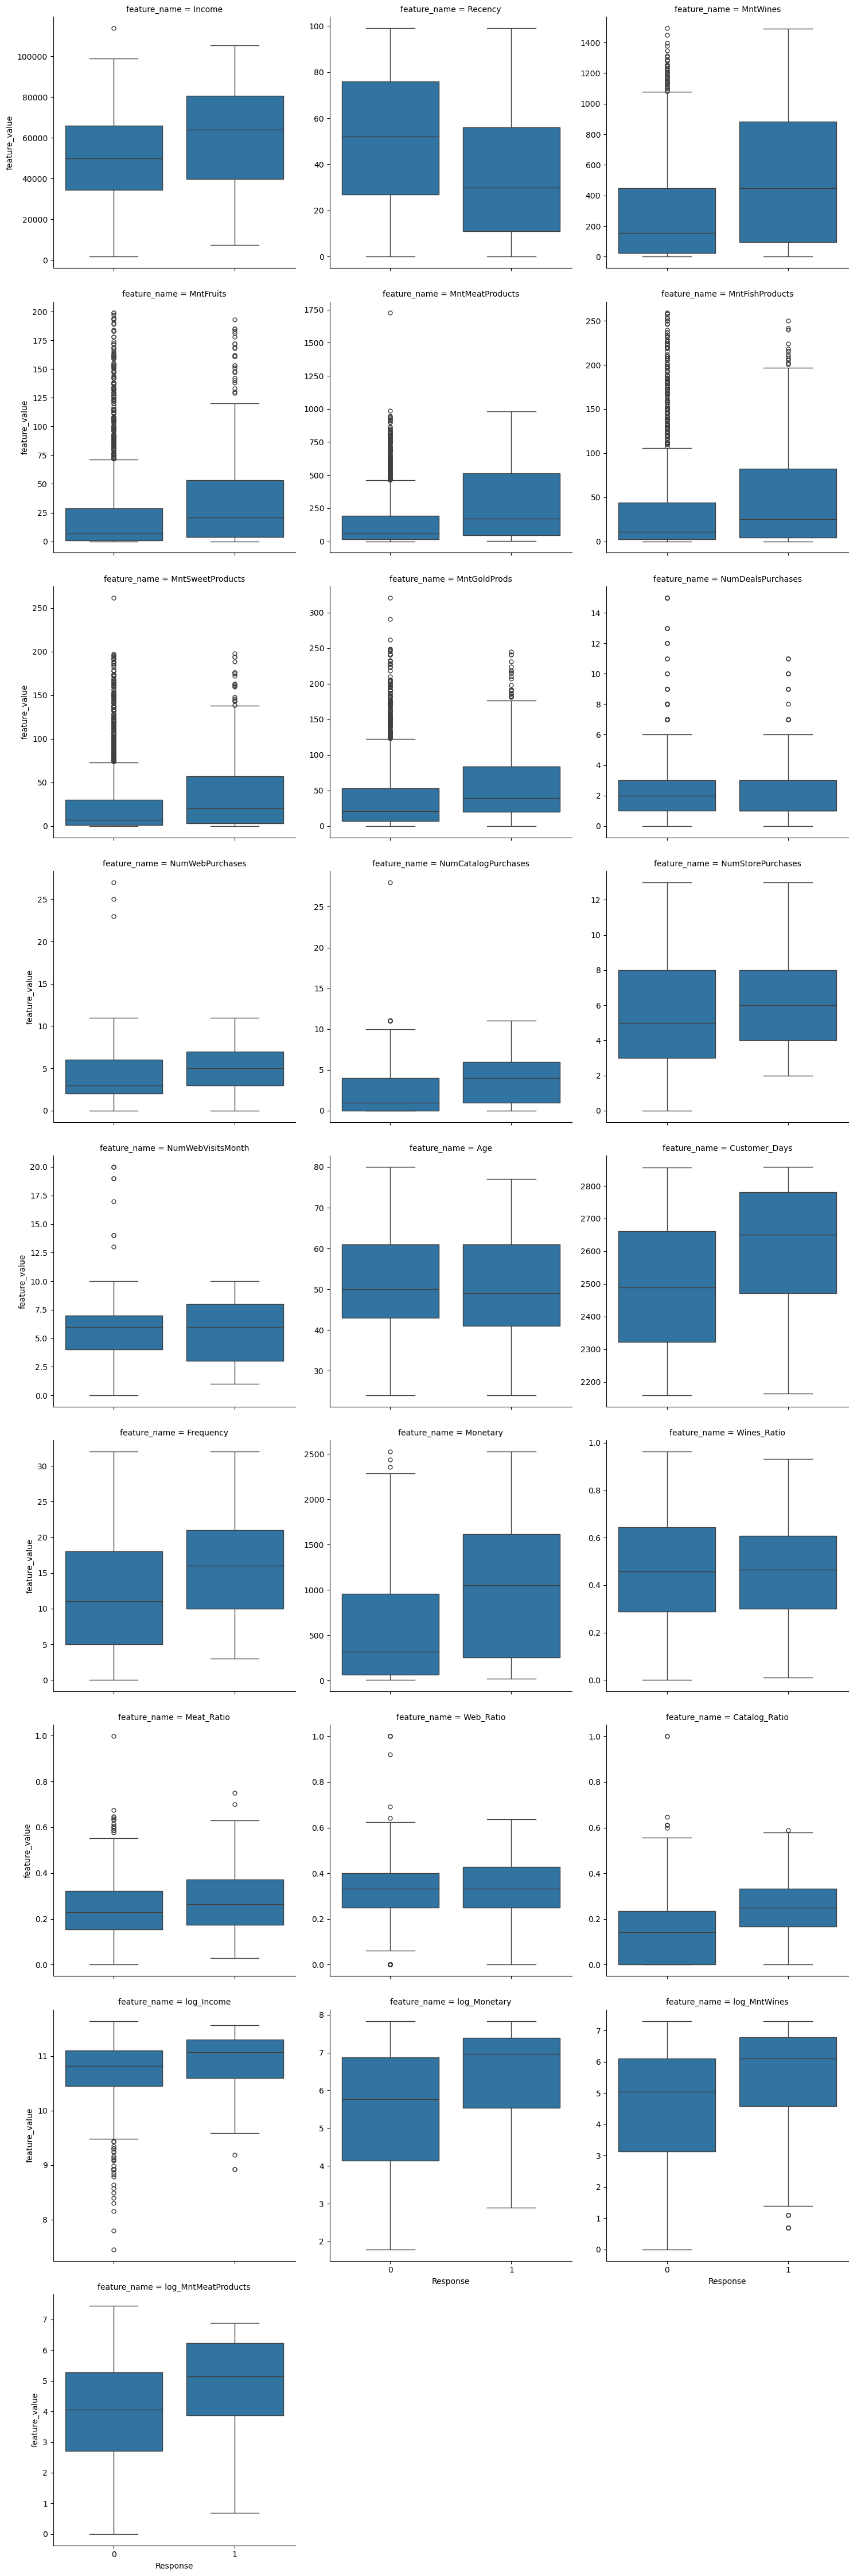

In [20]:
# Box plot for the distribution of numerical features
data_melted = data[numerical_columns + ['Response']].melt(id_vars='Response', value_vars=numerical_columns, 
                        var_name='feature_name', value_name='feature_value')

sns.catplot(kind='box', data=data_melted, x='Response', y='feature_value', col='feature_name', col_wrap=3, sharey=False)

Customers with Response = 1 tend to have: 
* Higher income
* Lower recency (their last purchase is more recennt)
* Higher customer_days (have been customers for a longer time)
* More frequent purchases on different things

The features that don't have strong correlation with the response are: 
* Purchase channels
* Age

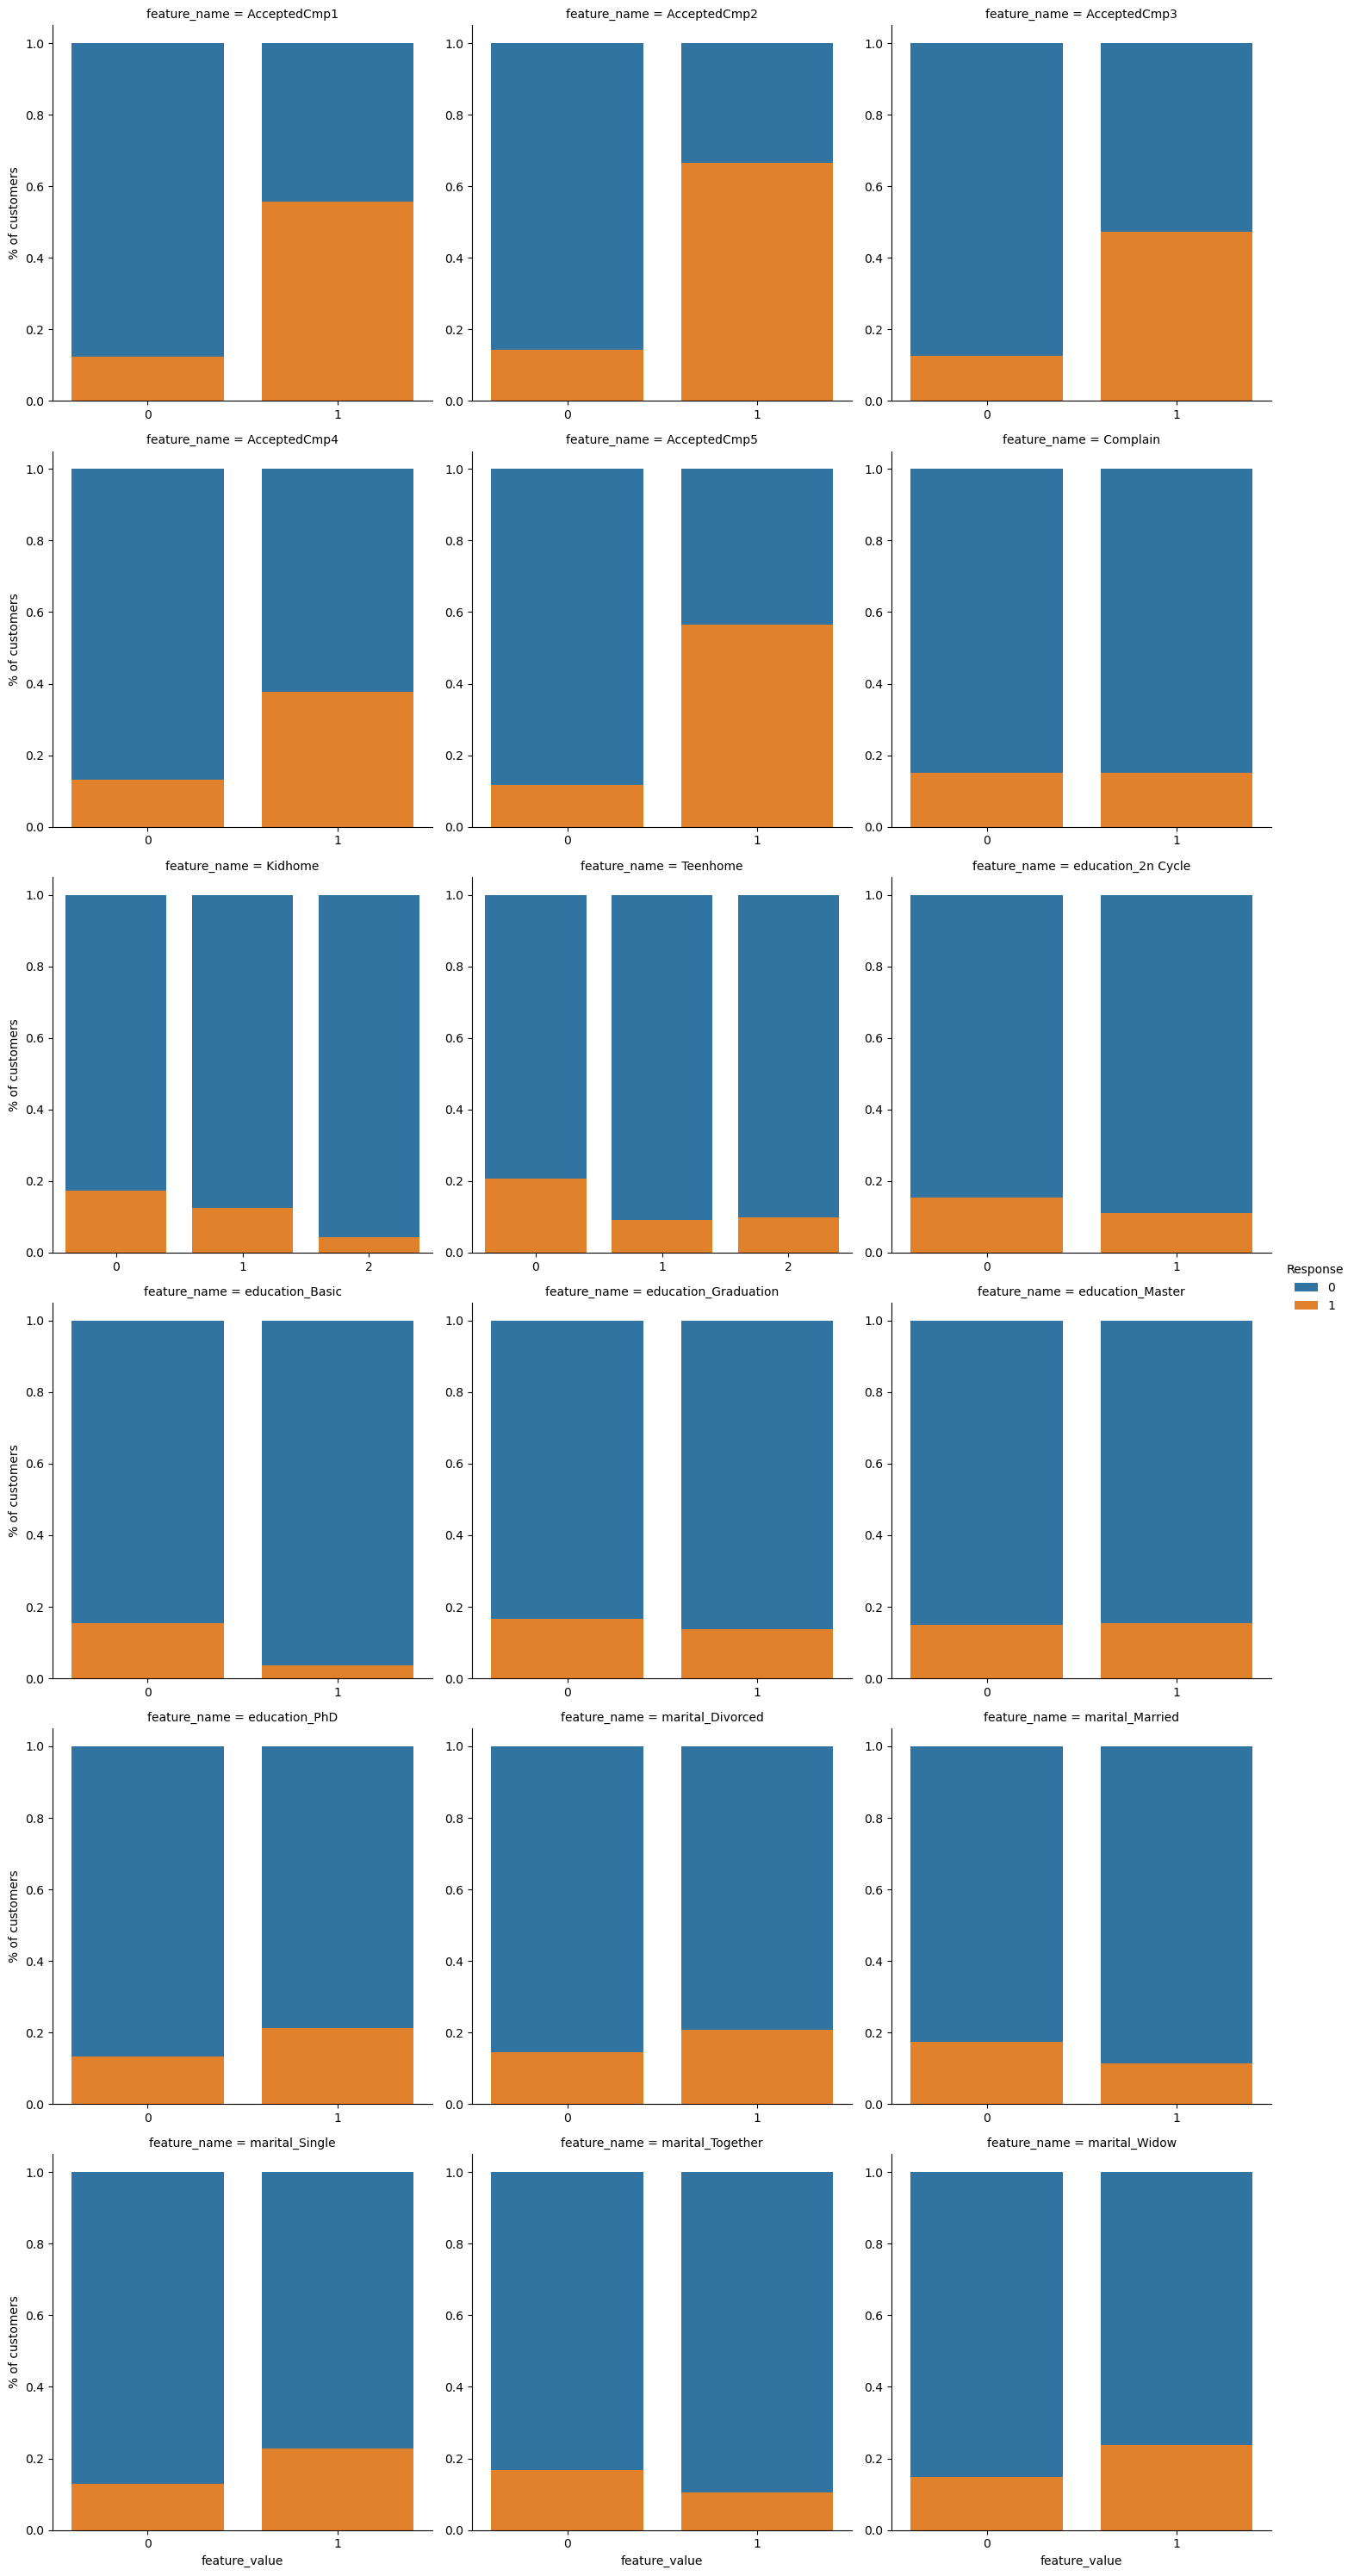

In [21]:
# Bar chart for the distribution of categorical features

data_melted = data[categorical_columns + ['Response']].melt(id_vars='Response', value_vars=categorical_columns, 
                        var_name='feature_name', value_name='feature_value')
data_melted['count'] = 1


data_melted = data_melted.groupby(['feature_name','feature_value','Response'])[['count']].sum().reset_index(names=['feature_name','feature_value','Response'])
data_melted.sort_values(['feature_name','feature_value','Response'], ascending=[True,True,False],inplace=True) 
data_grouped_total = data_melted.groupby(['feature_name','feature_value'])[['count']].sum().reset_index(names=['feature_name','feature_value'])
data_melted = data_melted.merge(data_grouped_total, on=['feature_name','feature_value'])
data_melted['pctg_count'] = data_melted['count_x'] / data_melted['count_y']
data_melted['% of customers'] = data_melted.groupby(['feature_name','feature_value']).rolling(2, min_periods=1).sum()['pctg_count'].values


sns.catplot(kind='bar', data=data_melted, x='feature_value', y='% of customers', hue='Response', col='feature_name', col_wrap=3, sharey=False, sharex=False, estimator='sum', dodge=False)

Customers with Response = 1 tend to: 
* have accepted previous campaigns
* have no children and teens
* not have a partner (divorced, single, or widow)

The features that don't have strong correlation with the response are: 
* Complain

Education is a bit complicated, since people without a basic education level can have a higher response rate than those who don't and people with PHD degree can have a higher response rate than those who don't.

Generally, a customer with a higher response rate should: 
* have a high income level and spends frequently and recently
* have been a customer for a long time
* have responded to previous campaigns
* not have children or partner

## Identify Features Correlated with the Response
Using ANOVA for numerical features and Chi-squared tests of independence for categorical features

In [22]:
# ANOVA
result = []
for c in numerical_columns:
    negative_response = data[data['Response'] == 0][c].values
    positive_response = data[data['Response'] == 1][c].values
    p_value = f_oneway(negative_response, positive_response).pvalue
    result.append([c, p_value])

pd.DataFrame(result, columns=['feature', 'p-value']).sort_values('p-value', ascending=True)

,feature,p-value
16,Monetary,6.347534e-37
20,Catalog_Ratio,2.495422e-33
4,MntMeatProducts,1.810731e-32
2,MntWines,1.216773e-31
10,NumCatalogPurchases,6.226722e-29
24,log_MntMeatProducts,3.703269e-26
22,log_Monetary,4.410344e-24
1,Recency,2.056815e-21
14,Customer_Days,1.233380e-20
0,Income,1.315994e-16


The story is similar with the visualisation's. The top rows, numerical features with lower p-values, have higher correlation with the response.

In [23]:
# Chi-squared
result = []
for c in categorical_columns:
    contingency_table = pd.crosstab(data[c], data['Response'])
    p_value = chi2_contingency(contingency_table).pvalue # Perform Chi-squared test
    result.append([c, p_value])

pd.DataFrame(result, columns=['feature', 'p-value']).sort_values('p-value', ascending=True)

,feature,p-value
4,AcceptedCmp5,1.021640e-51
5,AcceptedCmp1,1.822433e-43
2,AcceptedCmp3,4.210775e-32
3,AcceptedCmp4,8.348030e-17
6,AcceptedCmp2,1.528330e-14
1,Teenhome,2.524076e-13
10,marital_Single,1.386801e-07
17,education_PhD,3.528371e-05
9,marital_Married,1.990126e-04
11,marital_Together,5.859672e-04


The story is similar with the visualisation's. The top rows, categorical features with lower p-values, have higher correlation with the response.

## Data Modeling

In [24]:
# Deal with imbalance
rawdata = data[numerical_columns + categorical_columns + ['Response']]
X_train, X_test, y_train, y_test = train_test_split(rawdata.drop('Response', axis=1), rawdata['Response'], test_size=0.2, random_state=1)
print(y_train.mean(), y_test.mean())

0.15306122448979592 0.14285714285714285


In [25]:
# Building pipeline, preprocessor and grid search
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ],
    remainder='passthrough'
)

pipe = ImbPipeline([
    ('prep', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(max_iter=200))
])


grid = GridSearchCV(
    pipe,
    param_grid = [{
    'model': [XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)],
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 5],
    'model__learning_rate': [0.05, 0.1]
    }],
    scoring='precision',
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)  

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:58] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Income',
                                                                          'Recency',
                                                                          'MntWines',
                                                                          'MntFruits',
                                                                          'MntMeatProducts',
                                                                          'MntFishProducts',
                                                                          'MntSweetProducts',
                                                                          'MntGoldProds',
                                                                          'NumDealsPurchases',
                                                                          'NumWebPurchases',
                                                                          'NumCatalogPurchases',
                                                                          'NumStorePurchas...
                                                  max_cat_threshold=None,
                                                  max_cat_to_onehot=None,
                                                  max_delta_step=None,
                                                  max_depth=None,
                                                  max_leaves=None,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  monotone_constraints=None,
                                                  multi_strategy=None,
                                                  n_estimators=None,
                                                  n_jobs=None,
                                                  num_parallel_tree=None,
                                                  random_state=42, ...)],
                          'model__learning_rate': [0.05, 0.1],
                          'model__max_depth': [3, 5],
                          'model__n_estimators': [100, 200]}],
             scoring='precision')

In [26]:
# Baseline model
pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('model', None)
])

param_grid = [{
    'model': [LogisticRegression(), RandomForestClassifier(), XGBClassifier()]
}]

grid = GridSearchCV(pipe, param_grid=param_grid, scoring=['accuracy','precision','recall','f1','roc_auc'], refit='precision')
grid.fit(X_train, y_train)
results = pd.DataFrame(grid.cv_results_).sort_values('rank_test_precision')
results[['param_model','params'] + [x for x in results.columns if 'mean_test' in x]]

,param_model,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
0,LogisticRegression(),{'model': LogisticRegression()},0.901355,0.753014,0.528804,0.619557,0.910590
1,RandomForestClassifier(),{'model': RandomForestClassifier()},0.873580,0.678543,0.338944,0.449839,0.882074
2,"XGBClassifier(base_score=None, booster=None, c...","{'model': XGBClassifier(base_score=None, boost...",0.879244,0.642095,0.467216,0.538060,0.901361


The precision (proportion of true predictions being actually true) is satisfying, reaching 75.30% for random forest model. This is what we should care about because we want to maximize the response rate.

In [27]:
# Improve the model by defining a general purpose transformer
class GeneralTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, expr, feature_name_out='Undefined'):
        self.expr = expr
        self.feature_name_out = feature_name_out
    
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['result'] = X_copy.apply(lambda x: eval(self.expr), axis=1)
        return X_copy[['result']]
    
    def get_feature_names_out(self, input_features=None): 
        return np.array([self.feature_name_out])

In [28]:
# Combine all marital status features into 1 (have a partner or not)
is_single_columns = ['marital_Single','marital_Divorced','marital_Widow','marital_Married','marital_Together']

pipe = Pipeline([
    ('preprocessing', ColumnTransformer([
        ('categorical', ColumnTransformer([('is_Single',GeneralTransformer(expr='1 if x.iloc[0] == 1 or x.iloc[1] == 1 or x.iloc[2] == 1 else 0'), is_single_columns)], remainder='passthrough'), categorical_columns),
        ('numerical', StandardScaler(), numerical_columns)
    ])),
    ('model', None)
])

param_grid = [{
    'model': [LogisticRegression(), RandomForestClassifier(), XGBClassifier()]
}]

grid = GridSearchCV(pipe, param_grid=param_grid, scoring=['accuracy','precision','recall','f1','roc_auc'], refit='precision')
grid.fit(X_train, y_train)
results = pd.DataFrame(grid.cv_results_).sort_values('rank_test_precision')
results[['param_model','params'] + [x for x in results.columns if 'mean_test' in x]]

,param_model,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
0,LogisticRegression(),{'model': LogisticRegression()},0.900787,0.757215,0.517888,0.613135,0.914444
1,RandomForestClassifier(),{'model': RandomForestClassifier()},0.871887,0.679998,0.307250,0.417833,0.890097
2,"XGBClassifier(base_score=None, booster=None, c...","{'model': XGBClassifier(base_score=None, boost...",0.886608,0.670370,0.502810,0.574374,0.907988


Precision overall slightly improved. The model with best performance is now logistic regress, with a precision of 75.72%. The model also become more lightweight.

In [29]:
# Combine all children columns into one (have children/teens or not)
is_single_columns = ['marital_Single','marital_Divorced','marital_Widow','marital_Married','marital_Together']
has_children_columns = ['Kidhome','Teenhome']

pipe = Pipeline([
    ('preprocessing', ColumnTransformer([
        ('categorical', ColumnTransformer([('is_Single',GeneralTransformer(expr='1 if x.iloc[0] == 1 or x.iloc[1] == 1 or x.iloc[2] == 1 else 0'), is_single_columns),
                                           ('has_Children',GeneralTransformer(expr='1 if x.iloc[0] == 0 and x.iloc[1] == 0 else 0'), has_children_columns)], remainder='passthrough'), categorical_columns),
        ('numerical', StandardScaler(), numerical_columns)
    ])),
    ('model', None)
])

param_grid = [{
    'model': [LogisticRegression(), RandomForestClassifier(), XGBClassifier()]
}]

grid = GridSearchCV(pipe, param_grid=param_grid, scoring=['accuracy','precision','recall','f1','roc_auc'], refit='precision')
grid.fit(X_train, y_train)
results = pd.DataFrame(grid.cv_results_).sort_values('rank_test_precision')
results[['param_model','params'] + [x for x in results.columns if 'mean_test' in x]]

,param_model,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
0,LogisticRegression(),{'model': LogisticRegression()},0.896248,0.739329,0.499440,0.594032,0.911163
1,RandomForestClassifier(),{'model': RandomForestClassifier()},0.873020,0.676658,0.328771,0.439404,0.883810
2,"XGBClassifier(base_score=None, booster=None, c...","{'model': XGBClassifier(base_score=None, boost...",0.883207,0.663704,0.484529,0.558565,0.905969


In [30]:
# Combine all amount spent columns into one
is_single_columns = ['marital_Single','marital_Divorced','marital_Widow','marital_Married','marital_Together']
has_children_columns = ['Kidhome','Teenhome']
total_spend_columns = ['MntWines', 'MntFruits', 'MntMeatProducts','MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

pipe = Pipeline([
    ('preprocessing', ColumnTransformer([
        ('categorical', ColumnTransformer([('is_Single',GeneralTransformer(expr='1 if x.iloc[0] == 1 or x.iloc[1] == 1 or x.iloc[2] == 1 else 0'), is_single_columns),
                                           ('has_Children',GeneralTransformer(expr='1 if x.iloc[0] == 0 and x.iloc[1] == 0 else 0'), has_children_columns)], remainder='passthrough'), categorical_columns),
        ('numerical', Pipeline([('numerical_calculations', ColumnTransformer([('total_spend',GeneralTransformer(expr='sum(x)'),total_spend_columns)], remainder='passthrough')),
                                ('scaler', StandardScaler())]), numerical_columns)
    ])),
    ('model', None)
])

param_grid = [{
    'model': [LogisticRegression(), RandomForestClassifier(), XGBClassifier()]
}]

grid = GridSearchCV(pipe, param_grid=param_grid, scoring=['accuracy','precision','recall','f1','roc_auc'], refit='precision')
grid.fit(X_train, y_train)
results = pd.DataFrame(grid.cv_results_).sort_values('rank_test_precision')
results[['param_model','params'] + [x for x in results.columns if 'mean_test' in x]]

,param_model,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
0,LogisticRegression(),{'model': LogisticRegression()},0.899649,0.756214,0.519687,0.612292,0.910920
1,RandomForestClassifier(),{'model': RandomForestClassifier()},0.873022,0.676788,0.317702,0.425598,0.886459
2,"XGBClassifier(base_score=None, booster=None, c...","{'model': XGBClassifier(base_score=None, boost...",0.882072,0.647877,0.513706,0.570539,0.904042


Models keep improving. The best model is now logistic regression with a precision of 75.62%.

In [31]:
grid.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('is_Single',
                                                                                   GeneralTransformer(expr='1 '
                                                                                                           'if '
                                                                                                           'x.iloc[0] '
                                                                                                           '== '
                                                                                                           '1 '
                                                                                                           'or '
                                                                                                           'x.iloc[1] '
                                                                                                           '== '
                                                                                                           '1 '
                                                                                                           'or '
                                                                                                           'x.iloc[2] '
                                                                                                           '== '
                                                                                                           '1 '
                                                                                                           'else '
                                                                                                           '0'),
                                                                                   ['marital_Single',
                                                                                    'marital_Divorced',
                                                                                    'marital_Widow',
                                                                                    'marital_Married',
                                                                                    'marital_Together']),
                                                                                  ('has...
                                                   'MntFishProducts',
                                                   'MntSweetProducts',
                                                   'MntGoldProds',
                                                   'NumDealsPurchases',
                                                   'NumWebPurchases',
                                                   'NumCatalogPurchases',
                                                   'NumStorePurchases',
                                                   'NumWebVisitsMonth', 'Age',
                                                   'Customer_Days', 'Frequency',
                                                   'Monetary', 'Wines_Ratio',
                                                   'Meat_Ratio', 'Web_Ratio',
                                                   'Catalog_Ratio',
                                                   'log_Income', 'log_Monetary',
                                                   'log_MntWines',
                                                   'log_MntMeatProducts'])])),
                ('model', LogisticRegression())])

## Final Prediction

In [32]:
predictions = grid.predict(X_test)
actual = y_test
score = precision_score(actual, predictions)
print(f'Precision on test set = {score}')

Precision on test set = 0.7291666666666666


In [33]:
predicted_probs = grid.predict_proba(X_test)[:,1]
actual_class = y_test.values

all_customers = pd.DataFrame({'predicted_prob': predicted_probs,
                              'actual_class': actual_class}).sort_values('predicted_prob', ascending=False)
all_customers

,predicted_prob,actual_class
85,0.999456,1
125,0.988469,1
374,0.980437,1
66,0.959351,1
326,0.946229,1
...,...,...
235,0.000729,0
78,0.000538,0
224,0.000460,0
432,0.000155,0


In [34]:
results = []
for cutoff_prob in [0.5 + 0.05 * inc for inc in range(0,10)]:
    top_n_customer = all_customers[all_customers['predicted_prob'] >= cutoff_prob].shape[0] 
    precision = all_customers['actual_class'].values[:top_n_customer].mean() 
    results.append([cutoff_prob, precision, top_n_customer])

pd.DataFrame(results, columns=['cutoff_prob', 'precision', 'num_customers'])

,cutoff_prob,precision,num_customers
0,0.50,0.729167,48
1,0.55,0.707317,41
2,0.60,0.729730,37
3,0.65,0.806452,31
4,0.70,0.862069,29
5,0.75,0.904762,21
6,0.80,0.888889,18
7,0.85,0.933333,15
8,0.90,0.909091,11
9,0.95,1.000000,4


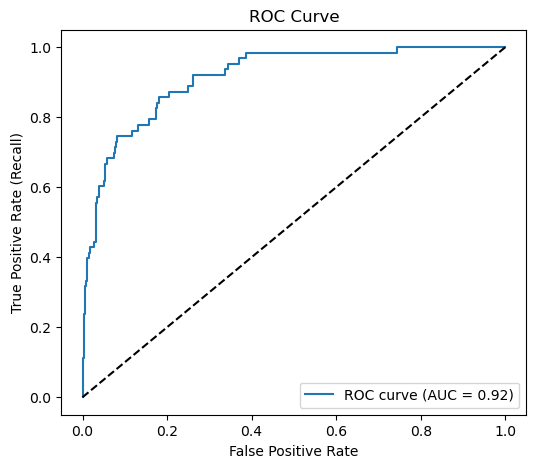

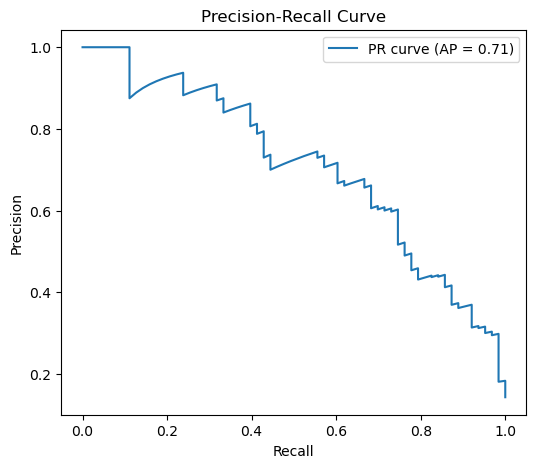

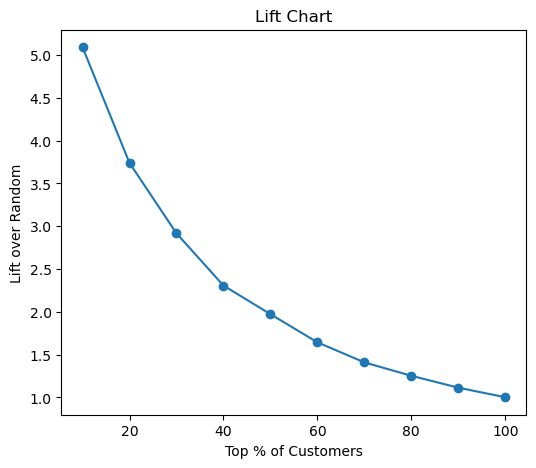

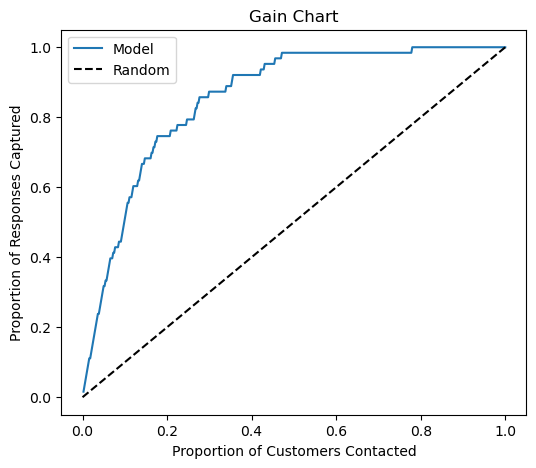

In [35]:
# Model Evaluation with ROC, PR, Lift, and Gain Charts
y_score = grid.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
# ROC
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.show()

# PR 
precision, recall, _ = precision_recall_curve(y_test, y_score)
ap = average_precision_score(y_test, y_score)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"PR curve (AP = {ap:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# Lift Chart 
sorted_idx = np.argsort(-y_score)  
y_sorted = y_test.values[sorted_idx]

n_groups = 10  
group_size = len(y_sorted) // n_groups
lift = []

for i in range(1, n_groups+1):
    top_n = y_sorted[:i*group_size]
    precision_top = top_n.mean()
    precision_random = y_test.mean()
    lift.append(precision_top / precision_random)

plt.figure(figsize=(6,5))
plt.plot(np.arange(1,n_groups+1)*10, lift, marker='o')
plt.xlabel("Top % of Customers")
plt.ylabel("Lift over Random")
plt.title("Lift Chart")
plt.show()

# Gain Chart 
cumulative_resp = np.cumsum(y_sorted) / y_sorted.sum()
perc_customers = np.arange(1, len(y_sorted)+1) / len(y_sorted)

plt.figure(figsize=(6,5))
plt.plot(perc_customers, cumulative_resp, label="Model")
plt.plot([0,1],[0,1],'k--', label="Random")
plt.xlabel("Proportion of Customers Contacted")
plt.ylabel("Proportion of Responses Captured")
plt.title("Gain Chart")
plt.legend()
plt.show()

# ROC confirms the model has strong classification ability.
# PR curve shows the precision-recall trade-off in an imbalanced setting.
# Lift and Gain charts translate model performance into direct business impact, 
# showing how marketing can be more effective by focusing on high-probability customers.

## Optimization

In [ ]:
best_model = grid.best_estimator_
y_pred_probs = best_model.predict_proba(X_test)[:, 1]
# Set the budget: Maximum number of customers to contact.
K = 100
num_customers = len(y_pred_probs)
print(f"Budget: Contacting a maximum of {K} out of {num_customers} customers.")

m = gp.Model("marketing_optimization")
x = m.addVars(num_customers, vtype=GRB.BINARY, name="contact")
m.setObjective(gp.quicksum(y_pred_probs[i] * x[i] for i in range(num_customers)), GRB.MAXIMIZE)
m.addConstr(gp.quicksum(x[i] for i in range(num_customers)) <= K, "budget")
m.optimize()

if m.status == GRB.OPTIMAL:
    print("\nOptimal solution found!")
    print(f"Total Expected Responses: {m.objVal:.2f}")
    customers_to_contact_indices = [i for i in x.keys() if x[i].X > 0.5]
    print(f"Number of Customers to Contact: {len(customers_to_contact_indices)}")
    selected_probs = {i: y_pred_probs[i] for i in customers_to_contact_indices}
    sorted_customers = sorted(selected_probs.items(), key=lambda item: item[1], reverse=True)
    print("\nTop 10 selected customers (Original DF Index and Probability):")
    for customer_idx, prob in sorted_customers[:10]:
        original_df_index = X_test.index[customer_idx]
        print(f"  Customer Index (in original data): {original_df_index}, Probability: {prob:.4f}")   
else:
    print("\nNo optimal solution found. Status code:", m.status)

Budget: Contacting a maximum of 100 out of 441 customers.
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2699662
Academic license 2699662 - for non-commercial use only - registered to yi___@andrew.cmu.edu
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 8845H w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Academic license 2699662 - for non-commercial use only - registered to yi___@andrew.cmu.edu
Optimize a model with 1 rows, 441 columns and 441 nonzeros
Model fingerprint: 0xc1cb0b01
Variable types: 0 continuous, 441 integer (441 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+02, 1e+02]
Found heuristic solution: objective 15.6479805
Presolve removed 1 rows and 441 columns
Presolve time: 0.02s


In [40]:
# -- SCENARIO 1: AVOIDING MARKETING FATIGUE --
print("\n-- SCENARIO 1: AVOIDING MARKETING FATIGUE (Using 'AcceptedCmp5') --")
# Business Goal: Avoid contacting customers who responded in the 5th campaign.
# This uses real data instead of simulation.

# Identify customers to exclude based on the 'AcceptedCmp5' column in the test set
customers_to_exclude_indices = X_test[X_test['AcceptedCmp5'] == 1].index
# Get the positional indices for our Gurobi model
customers_to_exclude_pos_indices = [i for i, idx in enumerate(X_test.index) if idx in customers_to_exclude_indices]
print(f"Using real data: {len(customers_to_exclude_pos_indices)} customers responded in campaign 5 and will be excluded.")

# Formulate the new optimization problem
m_fatigue = gp.Model("fatigue_optimization")
m_fatigue.setParam('OutputFlag', 0)
x_fatigue = m_fatigue.addVars(num_customers, vtype=GRB.BINARY, name="contact")

m_fatigue.setObjective(gp.quicksum(y_pred_probs[i] * x_fatigue[i] for i in range(num_customers)), GRB.MAXIMIZE)
m_fatigue.addConstr(gp.quicksum(x_fatigue[i] for i in range(num_customers)) <= K, "budget")

# ADDED CONSTRAINT: Do not contact customers from the exclusion list
m_fatigue.addConstrs((x_fatigue[i] == 0 for i in customers_to_exclude_pos_indices), name="exclude_fatigued")

m_fatigue.optimize()

print("\nResults for Fatigue-Aware Optimization:")
if m_fatigue.status == GRB.OPTIMAL:
    print(f"Total Expected Responses: {m_fatigue.objVal:.2f}")
    selected_count = sum(1 for v in x_fatigue.values() if v.X > 0.5)
    print(f"Number of Customers to Contact: {selected_count}")
    print("NOTE: The expected response may be lower because we skipped customers who responded in the last campaign.")
else:
    print("No optimal solution found for the fatigue-aware model.")


# -- SCENARIO 2: ENSURING FAIRNESS ACROSS EDUCATION LEVELS --
print("\n-- SCENARIO 2: FAIRNESS ACROSS EDUCATION LEVELS --")
# Business Goal: Ensure marketing efforts reach both lower and higher education segments.

# Define the two education segments based on columns in the test set
lower_edu_cols = ['education_2n Cycle', 'education_Basic']
higher_edu_cols = ['education_Graduation', 'education_Master', 'education_PhD']

# Identify customers in each segment
lower_edu_indices = X_test[(X_test[lower_edu_cols[0]] == 1) | (X_test[lower_edu_cols[1]] == 1)].index
higher_edu_indices = X_test[(X_test[higher_edu_cols[0]] == 1) | (X_test[higher_edu_cols[1]] == 1) | (X_test[higher_edu_cols[2]] == 1)].index

# Get the positional indices for our Gurobi model
lower_edu_pos_indices = [i for i, idx in enumerate(X_test.index) if idx in lower_edu_indices]
higher_edu_pos_indices = [i for i, idx in enumerate(X_test.index) if idx in higher_edu_indices]

print(f"Identified {len(lower_edu_pos_indices)} customers in the 'Lower Education' segment.")
print(f"Identified {len(higher_edu_pos_indices)} customers in the 'Higher Education' segment.")

# Formulate the new optimization problem
m_fairness = gp.Model("fairness_optimization")
m_fairness.setParam('OutputFlag', 0)
x_fairness = m_fairness.addVars(num_customers, vtype=GRB.BINARY, name="contact")

m_fairness.setObjective(gp.quicksum(y_pred_probs[i] * x_fairness[i] for i in range(num_customers)), GRB.MAXIMIZE)
m_fairness.addConstr(gp.quicksum(x_fairness[i] for i in range(num_customers)) <= K, "budget")

# ADDED CONSTRAINTS: Contact at least a certain number from each education segment.
min_lower_edu_contacts = 15
min_higher_edu_contacts = 30

m_fairness.addConstr(
    gp.quicksum(x_fairness[i] for i in lower_edu_pos_indices) >= min_lower_edu_contacts,
    "fairness_lower_edu"
)
m_fairness.addConstr(
    gp.quicksum(x_fairness[i] for i in higher_edu_pos_indices) >= min_higher_edu_contacts,
    "fairness_higher_edu"
)
print(f"Constraint added: Must contact at least {min_lower_edu_contacts} from 'Lower Education' segment.")
print(f"Constraint added: Must contact at least {min_higher_edu_contacts} from 'Higher Education' segment.")

m_fairness.optimize()

print("\nResults for Fairness-Aware Optimization:")
if m_fairness.status == GRB.OPTIMAL:
    print(f"Total Expected Responses: {m_fairness.objVal:.2f}")
    selected_count = sum(1 for v in x_fairness.values() if v.X > 0.5)
    contacted_lower_edu = sum(1 for i in lower_edu_pos_indices if x_fairness[i].X > 0.5)
    contacted_higher_edu = sum(1 for i in higher_edu_pos_indices if x_fairness[i].X > 0.5)
    print(f"Number of Customers to Contact: {selected_count}")
    print(f"Customers contacted in 'Lower Education' segment: {contacted_lower_edu} (met the minimum of {min_lower_edu_contacts})")
    print(f"Customers contacted in 'Higher Education' segment: {contacted_higher_edu} (met the minimum of {min_higher_edu_contacts})")
    print("NOTE: The expected response is likely lower because the model was forced to meet minimums for both education segments.")
else:
    print("No optimal solution found for the fairness-aware model.")


-- SCENARIO 1: AVOIDING MARKETING FATIGUE (Using 'AcceptedCmp5') --
Using real data: 33 customers responded in campaign 5 and will be excluded.

Results for Fatigue-Aware Optimization:
Total Expected Responses: 36.57
Number of Customers to Contact: 100
NOTE: The expected response may be lower because we skipped customers who responded in the last campaign.

-- SCENARIO 2: FAIRNESS ACROSS EDUCATION LEVELS --
Identified 59 customers in the 'Lower Education' segment.
Identified 382 customers in the 'Higher Education' segment.
Constraint added: Must contact at least 15 from 'Lower Education' segment.
Constraint added: Must contact at least 30 from 'Higher Education' segment.

Results for Fairness-Aware Optimization:
Total Expected Responses: 51.02
Number of Customers to Contact: 100
Customers contacted in 'Lower Education' segment: 15 (met the minimum of 15)
Customers contacted in 'Higher Education' segment: 85 (met the minimum of 30)
NOTE: The expected response is likely lower because th